# Задача понижения размерности


Часто мы хотим данные из пространства высокой размерности перевести в пространство более низкой размености с сохранением одного или нескольких свойств, например:
* объекты реконструируются с минимальной ошибкой,
* расстояние между объектами сохраняется.


Мотивация понижения размерности:

1. Многие алгоритмы показывают себя плохо на пространствах большой размерности ([проклятие размерности 📚[wiki]](https://en.wikipedia.org/wiki/Curse_of_dimensionality)).
2. Некоторые просто будут значительно дольше работать, при этом качество их работы не изменится от уменьшения размерности.
3. Понижение размерности позволяет использовать память более эффективно и подавать модели на обучение за один раз больше объектов.
4. Избавиться от шумовых признаков.
5. Задача визуализации: хочется взглянуть на наши объекты, а делать это в 100-мерном или 100000-мерном пространстве невозможно.
6. Удаление выбросов — в пространствах меньшей размерности можем их увидеть глазами.
7. Можем увидеть закономерности в данных: что они разделяются на явные кластеры и т. д.

## Manifold assumption

В машинном обучении часто используют предположение о многообразии (manifold assumption). Это предположение о том, что между признаками, описывающими реальные объекты, существуют некоторые нетривиальные связи. Вследствие этого данные заполняют не весь объем пространства признаков, а лежат на некоторой поверхности — на **многообразии** (manifold).

Если предположение верно, то каждый объект может быть достаточно точно описан новыми признаками в пространстве значительно меньшей размерности, чем исходное пространство признаков.

При этом мы будем терять часть информации об объектах. Но при выполнении предположения о многообразии (а оно почти всегда выполняется) и при правильных настройках алгоритма понижения размерности эти потери будут незначительны.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/manifold_assumption.png" width="600"></center>

В большинстве случаев это действительно правда. Каждое изображение лица размером 300×300 содержит 90,000 пикселей, но на самом деле реальные лица занимают гораздо меньшее пространство. Это связано с тем, что пиксели на изображении связаны между собой и не могут принимать любые значения. Не все комбинации значений создадут узнаваемое лицо, поэтому мы можем использовать методы понижения размерности, чтобы выделить важные характеристики и структуру данных.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/faces_in_space_of_smaller_dimension.png" width="600"></center>

## PCA (Метод главных компонент)

Метод главных компонент (Principal Component Analysys, PCA) — простейший линейный метод снижения размерности, описан [Пирсоном в 1901 году 📚[book]](http://pca.narod.ru/pearson1901.pdf).



<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/introduction_pca.png" width="900"/></center>

### Максимизация дисперсии выборки после понижения размерности

Рассмотрим простой пример для понимания интуиции, которая стоит за методом главных компонент.

У нас есть выборка объектов с двумя признаками $x_1$ и $x_2$, отобразим их на плоскости. Мы хотим, чтобы у нас был только один признак, который характеризует наши данные. Тогда наша задача — провести прямую через наши точки так, чтобы она наилучшим образом характеризовала наши данные

<img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/pca_dataset_example.png" width="400"/>

Проведем прямую вдоль максимального изменения данных и спроецируем точки на нее. Это и будет наша первая главная компонента.

<img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/first_component_example.png" width="900"/>

Теперь мы можем использовать только один признак, который лежит на новой оси, а любые отклонения от нее — это просто шум (в действительности определить, что является шумом в данных, — это нетривиальная задача).

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/proection_component.png" width="400"/></center>

Это то, как можно понимать интуицию работы PCA.

Для многомерного случая (например, при количестве признаков 200) мы бы делали то же самое:

1. Выбираем направление максимального изменения данных — это первая главная компонента.
2. Если данные описаны не полностью, то выбираем еще одно направление — перпендикулярное к первому, так, чтобы описать оставшееся изменение в данных.
3. Повторяем пункт 2, пока компонент не будет достаточно, вплоть до размерности исходного пространства. При этом каждая следующая компонента будет перпендикулярна предыдущим и объяснять меньше дисперсии, чем любая из них.

<img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/3d_to_2d_pca.png" width="1000"/>

### Практический пример использования PCA

Чтобы понять, как использовать PCA на практике, найдем главные компоненты для датасета и посмотрим, как распределится между ними дисперсия.

Скачаем датасет, на котором польза от понижения размерности видна более явно.

В данном датасете 977 признаков (нам сейчас не важно, какие), характеризующих клетки крови.

Загрузим датасет и подготовим данные:

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

scRNAseq = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/scRNAseq_CITEseq.txt",
    sep="\t",
)

x = scRNAseq.iloc[:, 0:-1]  # features
y = scRNAseq.iloc[:, -1]  # labels

# 2. Taking the log of the data.
x = np.log(x + 1)


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
print(f"dataset shape: {x.shape}")
x

dataset shape: (8617, 976)


,ABHD17A,ABHD5,ABI3,AC013264.2,AC017104.6,AC092580.4,AC093673.5,AC132872.2,ACRBP,ACSL1,...,MOUSE_Rtn4,MOUSE_Ppp1ca,MOUSE_Cald1,MOUSE_Rps26,MOUSE_Ctsl,MOUSE_Tnfrsf12a,MOUSE_Esd,MOUSE_Acta2,MOUSE_Arpc2,MOUSE_Calr
CTGTTTACACCGCTAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,4.406719,3.663562,5.087596,3.135494,4.897840,4.060443,4.077537,1.791759,4.204693,3.091042
CTCTACGGTGTGGCTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,4.330733,4.219508,4.454347,4.110874,4.356709,4.025352,4.262680,4.248495,3.970292,3.526361
AGCAGCCAGGCTCATT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,...,4.634729,4.248495,4.477337,4.110874,4.727388,4.317488,3.637586,3.332205,4.234107,4.343805
GAATAAGAGATCCCAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,4.605170,4.276666,4.477337,4.442651,4.219508,3.806662,4.394449,3.465736,4.143135,4.682131
GTGCATAGTCATGCAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,4.276666,4.488636,4.859812,4.077537,3.178054,3.401197,2.639057,6.306275,4.543295,3.465736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCGTGTAGATTAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000
GGCGTGTAGTGTACTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000
CGTATGCCGTCTTCTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147
TACACGACGCTCTTCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.693147,0.693147,0.000000,0.000000,1.098612,0.693147,0.693147,1.098612,1.098612,0.000000


Полезной информацией является коэффициент объясненной дисперсии (explained variance ratio) главной компоненты. Этот коэффициент является отношением между дисперсией главной компоненты и суммой дисперсий всех главных компонент. Он указывает долю выборочной дисперсии, которая лежит вдоль оси каждой главной компоненты.

В модуле PCA после `fit` можно получить explained variance ratio посредством обращения к полю `explained_variance_ratio_`, а explained variance — посредством обращения к полю `explained_variance_`.



Построим график с `explained_variance_ratio_` для 10 компонент.

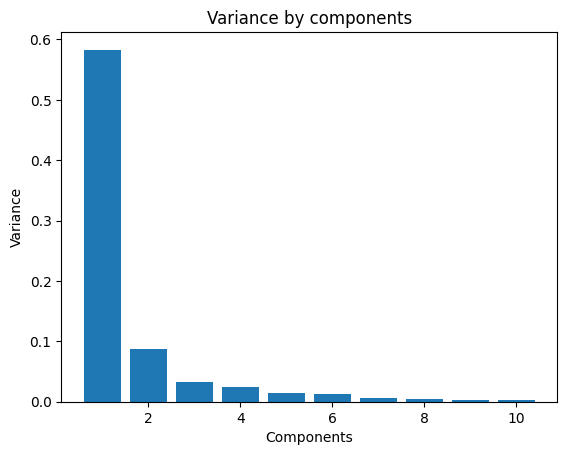

In [4]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Performing PCA with default number of principal components
pca = PCA(n_components=10)
pca.fit(x_train)  # fitting our PCA model with the training data
# Calculating the explained variance of each of the components
evr = pca.explained_variance_ratio_

# We are plotting the explained variance ratios
plt.bar(range(1, evr.shape[0] + 1), evr)
plt.title("Variance by components")
plt.xlabel("Components")
plt.ylabel("Variance")
plt.show()

In [5]:
pca.explained_variance_.shape

(10,)

Из графика не совсем понятно, сколько компонент брать. Резко доля объясняемой дисперсии меняется в районе 2-й компоненты. Посмотрим, сколько компонент нужно модели.

In [6]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=10)
pca.fit(x_train)
x_train_reduced = pca.transform(x_train)
x_test_reduced = pca.transform(x_test)

for i in range(1, 11):
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train_reduced[:, :i], y_train)

    print("%i first components %.2f" % (i, model.score(x_test_reduced[:, :i], y_test)))

1 first components 0.46
2 first components 0.78
3 first components 0.89
4 first components 0.93
5 first components 0.94
6 first components 0.94
7 first components 0.95
8 first components 0.96
9 first components 0.96
10 first components 0.96


Видим, что уже первых 8 компонент достаточно для достижения качества, которое далее не меняется.


Дело в том, что мы забыли сделать **стандартизацию** данных.

В датасете переменные имеют совершенно разные масштабы. Из-за этого часть из них "перетягивает" на себя всю дисперсию.

В результате по доле дисперсии судить о важности компонент нельзя.

Сделаем предварительно стандартизацию:

In [7]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

#  Fit the scaling model to our training data
x_train = scaler.fit_transform(x_train)

# Transform test set by applying the same scaling model
x_test = scaler.transform(x_test)

# Performing PCA with default number of principal components
pca = PCA(n_components=10)
pca.fit(x_train)  # fitting our PCA model with the training data

PCA(n_components=10)

В `PCA.components_` лежат векторы главных компонент, расположенные построчно (`n_components`, `n_features`).

In [8]:
pca.components_.shape

(10, 976)

Обратите внимание, что PCA упорядочивает собственные векторы. Это значит, что собственный вектор, соответствующий главной компоненте и, соответственно, имеющей максимальную дисперсию, будет находиться в первой строке.

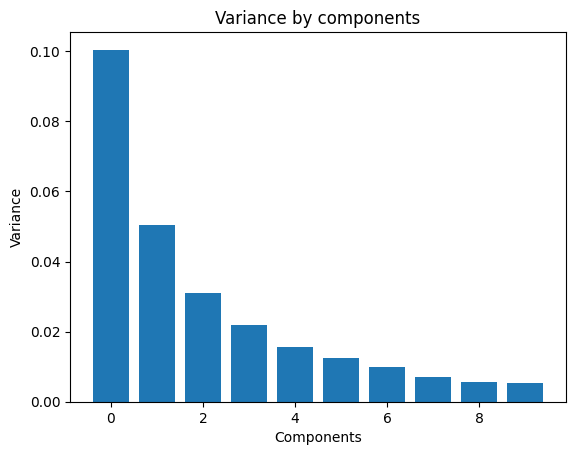

In [9]:
# Calculating the explained variance of each of the components
evr = pca.explained_variance_ratio_

# Plotting the explained variance ratios
plt.bar(range(evr.shape[0]), evr)
plt.title("Variance by components")
plt.xlabel("Components")
plt.ylabel("Variance")
plt.show()

Теперь видим, что не только первые две компоненты дают вклад. Это происходит потому, что переменные отмасштабированы.

Но и значимого спада в доле объясняемой дисперсии мы не видим, поэтому встает вопрос: как выбрать число компонент так, чтобы взять нужное и отсечь ненужное?

### Как выбирать оптимальное число  компонент




Существуют разные способы подбора оптимального числа компонент.

#### По доле объясняемой дисперсии

Мы можем выбрать порог по доле объясняемой дисперсии, например, 95%. Это быстрый способ, но не ясно, почему именно 95%, а не 90%.


724 components to 95% explained_variance_ratio


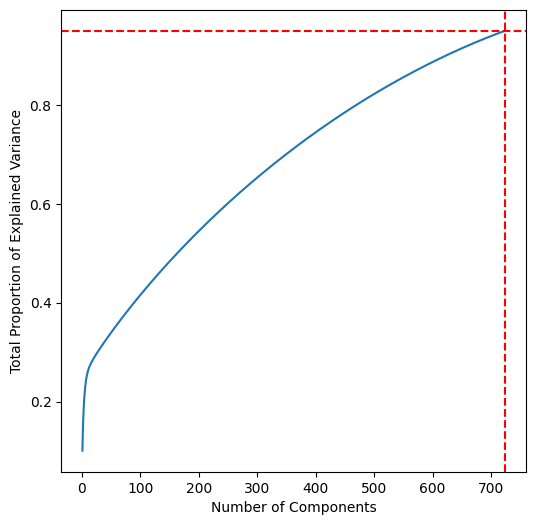

In [10]:
pca = PCA(0.95)
pca.fit(x_train)

total_explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6, 6))

plt.plot(np.arange(1, len(total_explained) + 1), total_explained)
plt.axhline(y=0.95, color="red", linestyle="--")
chosen_number = np.argmax(total_explained >= 0.95) + 1
plt.axvline(x=chosen_number, color="red", linestyle="--")
plt.ylabel("Total Proportion of Explained Variance")
plt.xlabel("Number of Components")
print(f"{chosen_number} components to 95% explained_variance_ratio")
plt.show()

Получилось 724 компоненты. При выборе другого порога получили бы другое количество компонент.


#### По правилу локтя

Можно построить график, отражающий, сколько дисперсии объясняет каждая из компонент, и на основе графика выбрать нужное число компонент.

Идея подхода простая: переход от компонент, объясняющих что-то важное в данных, к компонентам, объясняющим шум, должен сопровождаться резким снижением доли объясняемой дисперсии.

Или можно сказать иначе: выбранные нами компоненты должны быть устойчивы к добавлению шума в данные. Если мы нашли резкий скачок в доле объясняемой дисперсии, то маловероятно, что добавление шума этот скачок нивелирует — наш способ отбора компонент устойчив к шуму.

В идеальном случае график будет выглядеть как-то так. Но на практике таких склонов может не быть, а может быть несколько.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/elbow_rule.png" width="600"></center>

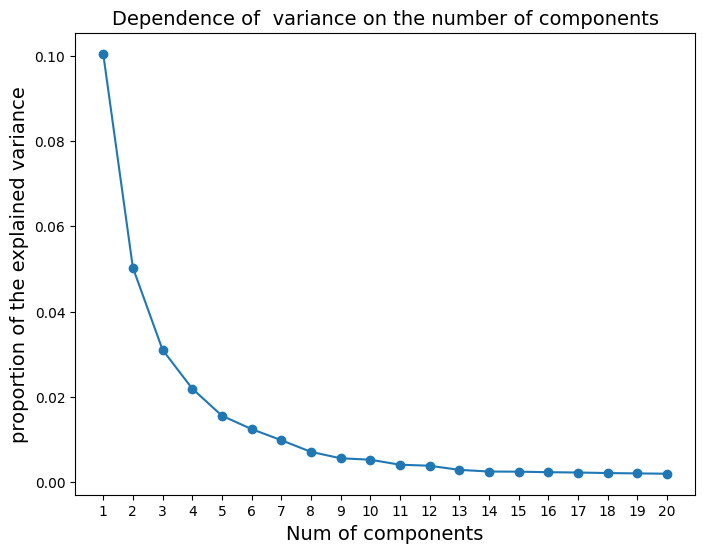

In [11]:
n_comp = 20
pca = PCA(n_comp)
pca.fit(x_train)
explained = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.scatter(np.arange(1, n_comp + 1), explained)
plt.plot(np.arange(1, n_comp + 1), explained)
plt.title("Dependence of  variance on the number of components", size=14)
plt.xlabel("Num of components", size=14)
plt.ylabel("proportion of the explained variance", size=14)
plt.xticks(np.arange(1, n_comp + 1))
plt.show()


Из такого графика сложно понять, какое число компонент стоит выбрать.

#### Перестановочный метод

Еще одним способом выбрать число главных компонент является перестановочный метод. Он заключается в следующем:

1. Для каждого признака перемешиваем его значения.
2. Создаём матрицу признаков, которая не содержит информации о первоначальной структуре данных.
3. Применяем метод главных компонент (PCA).
4. Любая доля объяснённой дисперсии в данном случае возникает из-за особенностей данных, а не реальной структуры.
5. Этот процесс повторяется многократно, например, 100–1000 раз.
6. Для определённой  $k$-й компоненты на реальных данных мы видим, какую часть дисперсии она объясняет.
7. Анализируем распределение доли дисперсии, которую $k$-я компонента объясняет в случайных данных (полученных перемешиванием).
8. Сравниваем это распределение с реальными данными, чтобы понять, объясняет ли $k$-я компонента что-то существенное или это просто случайный "шум".

In [12]:
from tqdm import tqdm


def shuffle_dataset(dataset):
    random_data = {
        col: np.random.permutation(dataset[col].values) for col in dataset.columns
    }
    return pd.DataFrame(random_data)


def get_variance_by_chance(dataset, n_replics, n_components):
    variance_explained_by_chance = np.empty((n_replics, n_components))
    for i in tqdm(range(n_replics)):
        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        variance_explained_by_chance[i, :] = random_pca.fit(
            random_data
        ).explained_variance_ratio_
    return variance_explained_by_chance


def calc_permutat_pval(real_values, permut_values, eps=None):
    eps = eps or (1 / (permut_values.shape[0] * 10))
    p_values = np.mean(permut_values >= real_values, axis=0) + eps
    return p_values


def pca_analysis(dataset, title, n_components=None, n_replics=100):
    n_components = n_components or dataset.shape[1]
    explained_variance = (
        PCA(n_components=n_components).fit(dataset).explained_variance_ratio_
    )
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_title(f"PCA {title}", size=15)
    ax1.set_xlabel("Component number", size=15)
    ax1.set_ylabel("Explained variance ratio", size=15)

    ax1.plot(explained_variance, label="real", lw=3)
    ax1.fill_between(
        range(explained_variance.shape[0]),
        np.mean(variance_by_chance, axis=0) + np.std(variance_by_chance, axis=0),
        np.mean(variance_by_chance, axis=0) - np.std(variance_by_chance, axis=0),
        color="red",
        lw=3,
        label="Chance",
    )

    ax2.set_title(f"PC significance, {title}", size=15)
    ax2.set_xlabel("Component number", size=15)
    ax2.set_ylabel("-log(pvalue + eps)", size=15)

    p_values = -np.log10(p_values)
    ax2.plot(p_values, lw=3)
    ax2.hlines(
        y=-np.log10(0.05),
        xmin=0,
        xmax=p_values.shape[0],
        color="red",
        linestyles="dashed",
        lw=3,
    )

    fig.tight_layout()

    return fig, (ax1, ax2)

100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


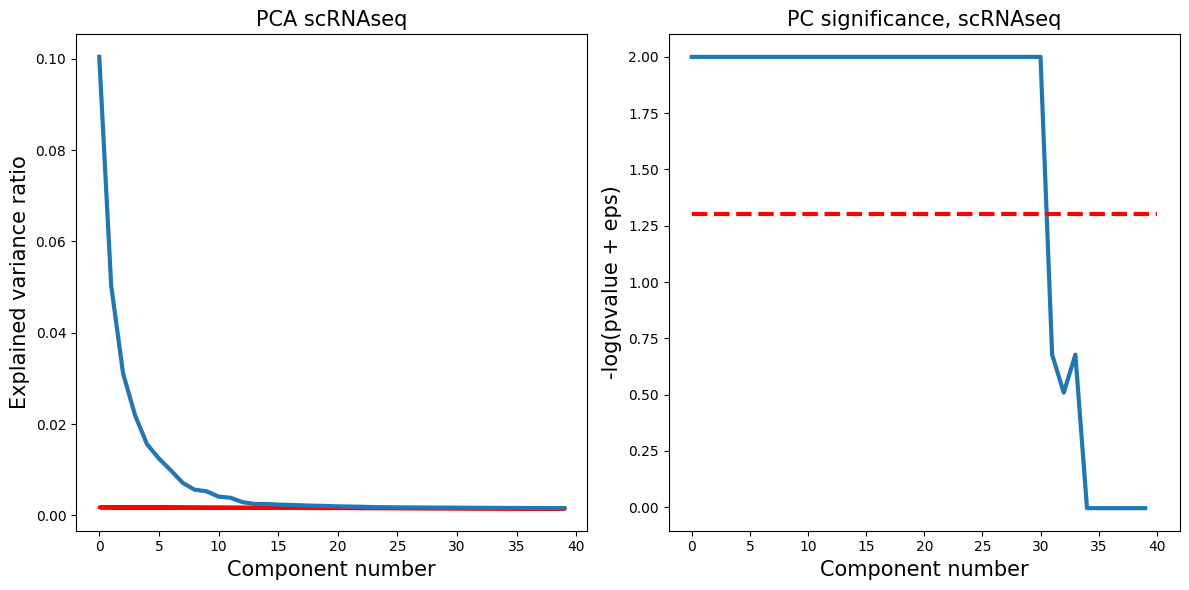

In [13]:
np.random.seed(42)
pca_analysis(pd.DataFrame(x_train), "scRNAseq", n_replics=10, n_components=40)
plt.show()

Явно видим, что, согласно этому подходу, надо взять 30 компонент.

[[arxiv] 🎓 Permutation methods for factor analysis and PCA](https://arxiv.org/abs/1710.00479) — статья с рассуждениями на тему "Почему это работает?"

### Пример с RNA-Seq — нахождение выбросов

Загрузим данные биологического анализа пациентов с раком и без него.


In [14]:
rnadataset = pd.read_table(
    "https://ml.gan4x4.ru/msu/datasets/rnaseq_data.tab.txt",
    index_col=0,
    header=None,
)
print("dataset shape: ", rnadataset.shape)

dataset shape:  (358, 71586)


In [15]:
rnadataset.columns = list(rnadataset.columns[:-2]) + ["dataset", "sample type"]
rnadataset.head()

,1,2,3,4,5,6,7,8,9,10,...,71577,71578,71579,71580,71581,71582,71583,71584,dataset,sample type
0,,,,,,,,,,,,,,,,,,,,,
GSM1296956,13.374975,3.536581,13.644486,3.929925,5.485977,9.363128,13.134106,4.318162,10.050190,10.605277,...,11.111910,6.889096,10.636753,6.656603,11.054070,6.914937,8.949687,8.982860,GSE53622,cancer
GSM1296957,13.555346,4.772572,14.153843,4.388201,5.412374,9.339831,13.789576,4.211175,11.242888,10.518348,...,10.998240,8.220715,10.645032,5.799432,10.951782,5.358962,8.951818,8.147058,GSE53622,normal
GSM1296958,13.396705,4.804828,13.948490,4.395992,5.627752,7.867446,13.424588,4.097212,10.568927,10.666406,...,10.498048,8.145627,11.452488,6.164146,11.492929,6.189310,9.091511,10.021106,GSE53622,cancer
GSM1296959,13.843843,4.563550,14.390648,4.697154,5.511075,8.943584,14.181927,4.766994,10.418466,10.924152,...,10.680012,8.450327,10.966135,6.482977,10.869259,6.683605,9.321499,9.278717,GSE53622,normal
GSM1296960,13.505687,4.750858,14.049400,4.476174,5.753380,8.475744,14.255647,4.344796,10.189663,10.651861,...,9.778142,7.615217,10.570247,5.861632,11.168351,6.343246,8.793520,11.562505,GSE53622,cancer


In [16]:
# We remove the dataset and sample type columns from the data frame and
# store the data frame in X
x = rnadataset.drop(labels=["dataset", "sample type"], axis=1)

# We store the dataset and sample type columns in the labels data frame
labels = rnadataset.loc[:, ["dataset", "sample type"]]

In [17]:
# Finding the top two principal components of the data
pca_decomposer = PCA(n_components=2)
pca_decomposer.fit(x)

PCA(n_components=2)

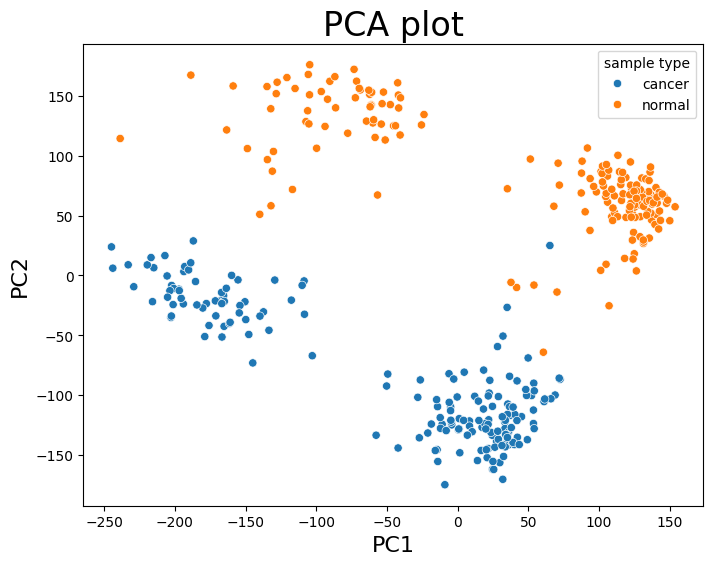

In [18]:
import seaborn as sns

x_reduced = pca_decomposer.transform(x)

# Display a scatterplot of the transformed dataset
plt.figure(figsize=(8, 6))
plt.title("PCA plot", size=24)
plt.xlabel("PC1", size=16)
plt.ylabel("PC2", size=16)
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:, 1], hue=labels["sample type"]);

Даже не понимая, что за признаки у нас в столбцах, мы видим несколько интересных вещей.

Во-первых, синяя точка на оранжевой территории и оранжевая на синей — видимо, выбросы.

Кроме этого мы видим, что почему-то у нас есть 4 почти равноудаленных кластера, по два на рак и нормальную ткань

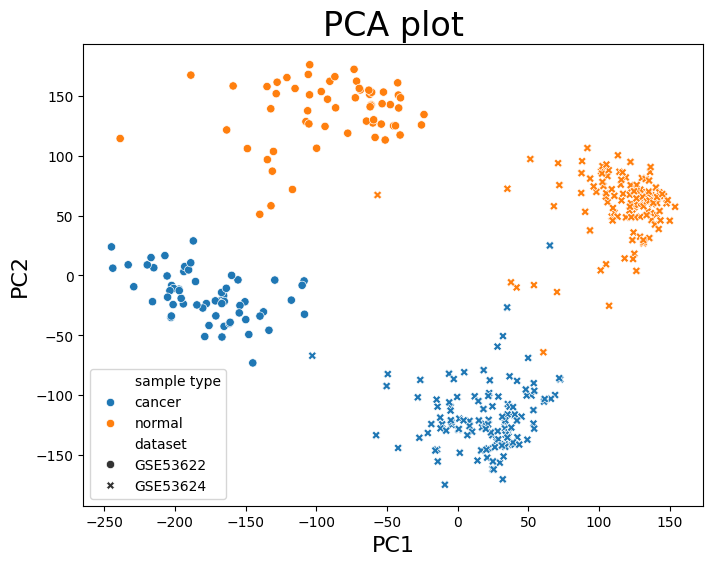

In [19]:
# Run PCA on the features
x_reduced = pca_decomposer.transform(x)

# Display a scatterplot of the transformed dataset
plt.figure(figsize=(8, 6))
plt.title("PCA plot", size=24)
plt.xlabel("PC1", size=16)
plt.ylabel("PC2", size=16)
sns.scatterplot(
    x=x_reduced[:, 0],
    y=x_reduced[:, 1],
    hue=labels["sample type"],
    style=labels["dataset"],
);

Видим, что в пределах данных одного эксперимента рак и опухоль разделяются хорошо. Но при этом данные между разными экспериментами отличаются так же, как и рак от опухоли.

Этот эффект называется батч-эффектом и говорит о том, что нужно нормализовывать данные в пределах эксперимента каким-то хитрым образом, чтобы научить модель на новых данных отличать рак от нормальной ткани.

Таким образом, с помощью PCA мы нашли выбросы и артефакт в данных.

Исправим это и стандартизируем данные внутри каждого эксперимента:

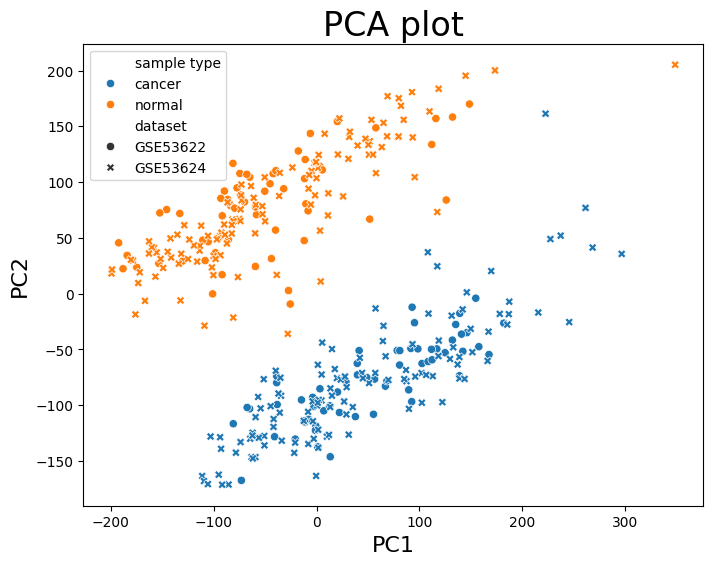

In [20]:
def standardize_group(group):
    scaler = StandardScaler()
    return pd.DataFrame(
        scaler.fit_transform(group), index=group.index, columns=group.columns
    )


x_standardized = x.groupby(labels["dataset"]).apply(standardize_group)

pca_decomposer = PCA(n_components=2)
x_reduced = pca_decomposer.fit_transform(x_standardized)

plt.figure(figsize=(8, 6))
plt.title("PCA plot", size=24)
plt.xlabel("PC1", size=16)
plt.ylabel("PC2", size=16)
sns.scatterplot(
    x=x_reduced[:, 0],
    y=x_reduced[:, 1],
    hue=labels["sample type"],
    style=labels["dataset"],
)
plt.show()

**Важно!** В данном примере мы опускаем момент с делением выборок, для упрощения. В реальной задаче стандартизировать нужно отдельные выборки.

### Недостатки  PCA




**Интересующее направление в данных может не совпадать с направлением максимальной дисперсии.**

Рассмотрим случай выборки, которая сгенерирована из двух вытянутых нормальных распределений, чьи основные оси неортогональны друг другу:

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/problem_pca_2.png" width="600"/></center>

**Выбранные оси могут не подходить для нашей задачи**

В примере ниже дисперсии не отражают интересующие нас направления в данных:

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/problem_pca_1.png" width="600"/></center>

В данном случае метод главных компонент будет считать вертикальную компоненту более значимой для описания набора данных, чем горизонтальную.

Но, например, в случае, когда данные из левого и правого кластеров относятся к разным классам, для их линейной разделимости вертикальная компонента является шумовой. Несмотря на это, метод главных компонент никогда ее шумовой не признает, и есть вероятность, что отбор признаков с его помощью выкинет из ваших данных значимые для решаемой вами задачи компоненты просто потому, что вдоль них значения имеют низкую дисперсию.

Справляться с такими ситуациями могут некоторые другие методы уменьшения размерности данных, например, метод независимых компонент (Independent Component Analysis, ICA).

PCA плохо справляется с нейлинейностью. Бывают ситуации, когда оптимально спроецировать не на некоторую плоскость, а на многообразие (кривая плоскость), как показано на картинке ниже.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/s_manifold.png" width="650"/></center>

В данном случае оптимально спроецировать на S-образную кривую.



## Kernel PCA (нелинейный) метод главных компонент

Как уже упоминалось, иногда невозможно захватить всю информацию линейной проекцией, хотя кривая поверхность с такой же размерностью это позволяет сделать. Одним из подходов к решению данной проблемы является задача перевода признаков в нелинейное пространство.

### Kernel trick

Kernel Trick избегает явного перевода наших признаков в пространство новых признаков, ведь пространства бывают очень большие, а нам бы хотелось сэкономить память компьютера.

Проекция вектора $\mathbf {x}$ на вектор $\mathbf {x'}$ производится через скалярное произведение: $\mathbf {x}^T \mathbf {x}$. Для PCA не важны собственно признаки объектов, а важны скалярные произведения между объектами.

И это скалярное произведение позволяет подсчитывать напрямую функция $k(\mathbf {x} ,\mathbf {x'})$, которую часто называют *ядром или ядерной функцией (kernel, kernel function)*.

Бывают разные ядра, которые считают скалярное произведение в разных пространствах:

* $\large k(x_i, x_j) = \dfrac{1}{z} e^{-\frac{h(x_i, x_j)^2}{h}}$ — радиальная базисная функция (RBF)
* $\large k(x_i, x_j) = (<x_i, x_j> + c)^d; c, d \in \mathbb{R}$ — полиномиальное ядро
* $\large k(x_i, x_j) = \sigma((<x_i, x_j>)$ — ядро с функцией активации

Рассмотрим на примере:

In [21]:
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html
from sklearn.datasets import make_circles

np.random.seed(42)
x, y = make_circles(n_samples=400, factor=0.3, noise=0.05, random_state=42)

Возьмем две концентрические окружности:

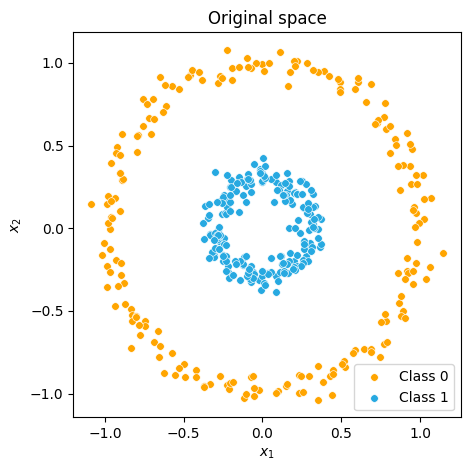

In [22]:
plt.figure(figsize=(5, 5))

plt.title("Original space")

class_0 = y == 0
class_1 = y == 1

sns.scatterplot(x=x[class_0, 0], y=x[class_0, 1], color="orange", s=30, label="Class 0")
sns.scatterplot(
    x=x[class_1, 0], y=x[class_1, 1], color="#27a9e1", s=30, label="Class 1"
)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

Обычный PCA не может их разделить:

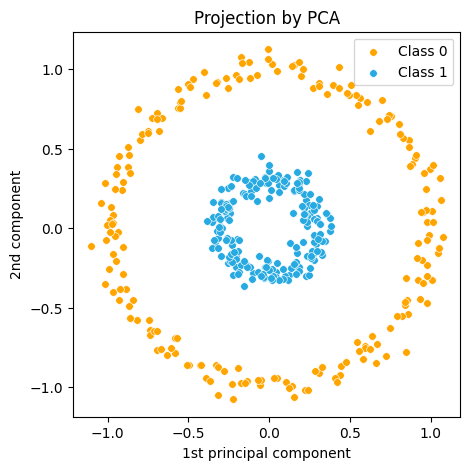

In [23]:
pca = PCA()
x_pca = pca.fit_transform(x)
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=x_pca[class_0, 0], y=x_pca[class_0, 1], color="orange", s=30, label="Class 0"
)
sns.scatterplot(
    x=x_pca[class_1, 0], y=x_pca[class_1, 1], color="#27a9e1", s=30, label="Class 1"
)
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")
plt.show()

А вот Kernel PCA справляется:

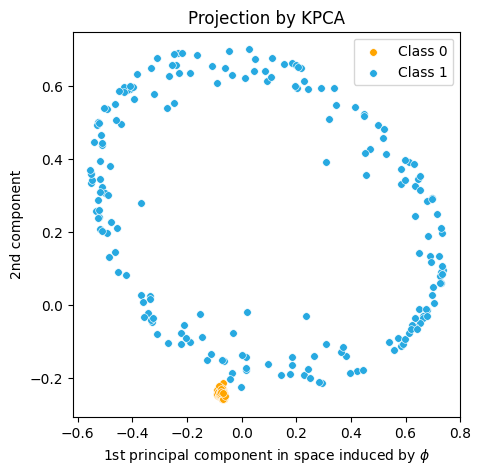

In [24]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
x_kpca = kpca.fit_transform(x)

plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=x_kpca[class_0, 0], y=x_kpca[class_0, 1], color="orange", s=30, label="Class 0"
)
sns.scatterplot(
    x=x_kpca[class_1, 0], y=x_kpca[class_1, 1], color="#27a9e1", s=30, label="Class 1"
)
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
plt.show()

Хотя, конечно, и восстанавливать он будет не идеально: работал-то он в пространстве бОльшей размерности и оси строил там.

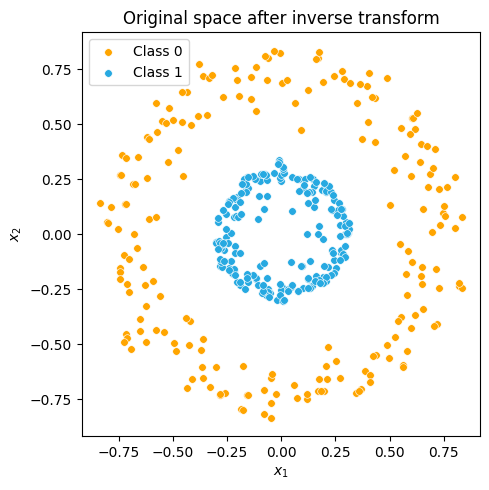

In [25]:
# 1. The 'kpca' variable is a KernelPCA object that is initialized with 'n_components' set to 2
# 2. Then it applies the kernel function specified in the 'kernel' variable  and then transforms the data based on the kernel, and gets the transformed data
# 3. Then it returns the transformed data
# 4. Then we get the inverse transformation by simply calling "kpca.inverse_transform(x_kpca)"
# 5. Finally, we plot the transformed data

x_back = kpca.inverse_transform(x_kpca)
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=x_back[class_0, 0], y=x_back[class_0, 1], color="orange", s=30, label="Class 0"
)
sns.scatterplot(
    x=x_back[class_1, 0], y=x_back[class_1, 1], color="#27a9e1", s=30, label="Class 1"
)
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

Kernel PCA довольно чувствителен к выбору ядра.

К примеру, для данных, расположенных на трех окружностях:

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/kernel_pca_three_circles.png" width="400"/></center>

в зависимости от выбора ядра мы будем получать совершенно разные отображение в спрямляющее пространство:

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/kernel_pca_different_kernels.png" width="600"/></center>

В связи с вышеописанными случаями, ниже мы рассмотрим более сильные методы.

Существуют и другие методы понижения размерности в данных. К примеру, t-SNE и UMAP.

Они немного иначе решают поставленную задачу: из пространства новой размерности мы не должны легко переходить в прежнее пространство. Взамен этого требуется, чтобы сохранялись расстояния между объектами. Причем, особое внимание уделяется расстояниям между близкими объектами. При этом расстояния между далекими объектами могут не сохраняться.

## t-SNE (t-distributed Stochastic Neighbor Embedding)

Идея состоит в том, чтобы не напрямую максимизировать дисперсию, а найти такое пространство, в котором расстояние между объектами будет сохраняться или по крайне мере не сильно меняться.

При этом будем больше беспокоиться о расстоянии между близкими объектами, нежели о расстоянии между далекими.

Рассмотрим алгоритм пошагово.

**Шаг 1:** Вычисляем матрицу попарных сходств объектов в пространстве исходной размерности. Затем преобразуем попарные сходства в условные вероятности.

Получаем, что объекты, считающиеся близкими в пространстве высокой размерности, имеют более высокую условную вероятность быть соседями и в пространстве низкой размерности.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/tsne_get_distance_matrix.png" width="650"/></center>

**Шаг 2:** Инициализируем начальное положение объектов в пространстве низкой размерности. Так как мы сгенирировали его случайно, видим, что они сильно отличаются.


<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/tsne_two_matrix_distance.png" width="600"/></center>

**Шаг 3:** Оптимизация. Осталось только привести сгенерированную матрицу к исходной. Делаем это с помощью градиентного спуска, минимизируя функцию потерь — [дивергенцию Кульбака — Лейблера 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9A%D1%83%D0%BB%D1%8C%D0%B1%D0%B0%D0%BA%D0%B0_%E2%80%94_%D0%9B%D0%B5%D0%B9%D0%B1%D0%BB%D0%B5%D1%80%D0%B0):

$$KL(P||Q) = \sum_{i \neq j}{p_{ij} \log \frac{p_{ij}}{q_{ij}}},$$

где:

$p_{ij}$ — условная вероятность близости между объектами $i$ и $j$ в пространстве исходной размерности,

$q_{ij}$ — условная вероятность близости между объектами $i$ и $j$ в пространстве низкой размерности.

В итоге мы хотим получить такое представление, чтобы объекты, которые находились близко в исходном пространстве, **наиболее вероятно** находились близко и в новом представлении.

**Физическая аналогия:**

Представьте себе комнату, в которой в воздухе висят шарики (наши объекты), которые соединены недеформированными пружинками, и время заморожено. Мы хотим из 3-мерного пространства (шарики в объеме комнаты), сделать представление в 2-мерном (шарики лежат на полу).

Если разморозить время, шарики упадут на пол. Тогда пружинки начнут стягивать шарики, которые были близки, и отталкивать шарики, которые упали близко, но были далеки. После того, как все шарики прекратят движение по полу и система из связанных шариков окажется в состоянии покоя, распределение расстояний между шариками на плоскости будет приближением для исходного распределения расстояний в объеме комнаты. Эта физическая аналогия показывает то, что происходит при минимизации дивергенции Кульбака — Лейблера.

Можем увидеть такой эффект на демонстрации:

In [26]:
# source: https://bost.ocks.org/mike/
from IPython.display import HTML

!wget -qN https://ml.gan4x4.ru/msu/dep-2.2/L04/tSNE.html

HTML(filename="./tSNE.html")

### Пример применения

Мы будем применять t-SNE не на исходных данных, а на 9-ти первых компонентах PCA. Для того, чтобы t-SNE сходился лучше, в качестве изначальных координат точек в новом пространстве можно использовать не случайный шум, а первые две компоненты PCA.

Преследуем две цели: уменьшить время работы t-SNE (который работает очень медленно) и убрать эффект шума на t-SNE — он может на него реагировать, особенно при условии, что схождения к минимуму мы можем не дождаться.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.036s...
[t-SNE] Computed neighbors for 8617 samples in 0.893s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 0.412418
[t-SNE] Computed conditional probabilities in 0.322s
[t-SNE] Iteration 50: error = 73.6012802, gradient norm = 0.0086984 (50 iterations in 8.747s)
[t-SNE] Iteration 100: error = 73.2053909, gradient norm = 0.0022528 (50 iterations in 7

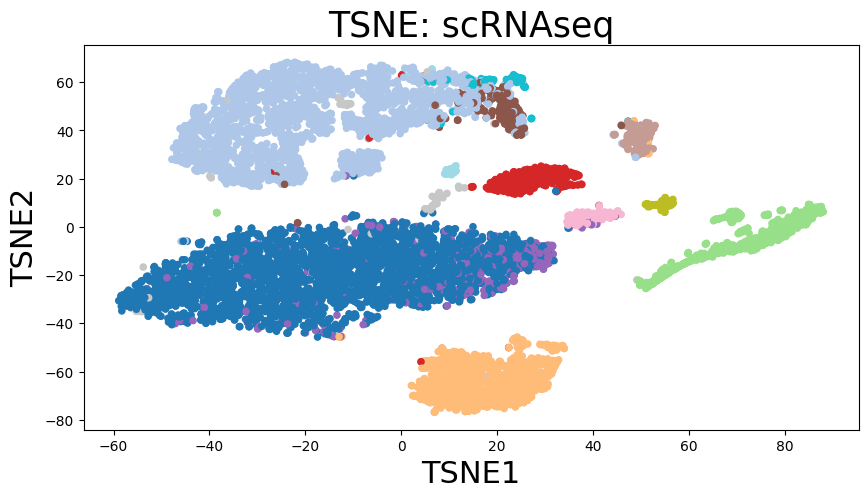

In [27]:
from sklearn import manifold

# 1. Firstly we reduce the dimensionality of the data to 6 features using PCA.
# 2. Then we take the first two PCA components and use this
#    as an initial approximation for the t-SNE algorithm.
# 3. Then we fit t-SNE on the data and plot the first two dimensions
#    of the t-SNE output, which are represented in green.
# 4. The visualization makes clear that there are district clusters in our data


scRNAseq = pd.read_csv(
    "https://ml.gan4x4.ru/msu/datasets/scRNAseq_CITEseq.txt",
    sep="\t",
)

x = scRNAseq.iloc[:, 0:-1]  # features
y = scRNAseq.iloc[:, -1]  # labels

# taking the log of the data.
x = np.log(x + 1)

x_reduced = PCA(n_components=9).fit_transform(x)

model = manifold.TSNE(
    n_components=2,
    init=x_reduced[:, 0:2],  # often use as a reasonable approximation
    perplexity=40,  # important parameter
    verbose=2,
    learning_rate="auto",
)

manifold = model.fit_transform(x_reduced)

plt.figure(figsize=(10, 5))
plt.scatter(manifold[:, 0], manifold[:, 1], c=y, cmap="tab20", s=20)
plt.title("TSNE: scRNAseq", fontsize=25)
plt.xlabel("TSNE1", fontsize=22)
plt.ylabel("TSNE2", fontsize=22)
plt.show()



И покрасим по разметке, которая нам известна из эксперимента. Видим, что разделение очень хорошее.

### Важные параметры t-SNE



`perplexity` — чем больше **perplexity**, тем более глобально мы смотрим на структуру.

`metric` — как считаются расстояния между точками — **metric**. По умолчанию используется евклидово расстояние, но часто помогают и другие (например, косинусное).

`learning_rate` — шаг градиентного спуска, тоже влияет на полученное представление.

### Проблемы t-SNE




* **Стохастичность**

Низкоразмерное представление, которое вы получите, будет отличаться между
запусками, если не зафиксировать **random seed**. Может отличаться довольно сильно.

* **Добавление новых точек**

Если у вас появились новые данные, то добавить их на  представление, полученное при помощи t-SNE ранее — нетривиальная задача.
Для разных областей есть свои "подгоны", но все это эвристика.

* **Расстояния не отражают реальную структуру**

Расстояния между кластерами точек могут ничего не значить (плохо сохраняются далекие расстояния):

<img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/tsne_problems_distances_between_clusters_no_matter.png" width="1000"/>

* **Искажение размера кластеров**

Размеры кластеров ничего не значат и могут сильно отличаться от исходных:

<img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/tsne_problems_cluster_size_no_matter.png" width="1000"/>

* **Искажение структуры**

Можно увидеть не ту структуру, которая по идее должна быть:

<img src="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/tsne_problems_erroneous_structure.png" width="1000"/>

Из-за указанных  недостатков результат t-SNE нужно с осторожностью использовать для кластеризации.

[[demo] 🎮 How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)

[[video] 📺 StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM)

[[article] 🎓 The art of using t-SNE for single-cell transcriptomics](https://www.nature.com/articles/s41467-019-13056-x) — cтатья по применению t-SNE в биологии

## UMAP



UMAP — uniform manifold approximation and projection.

[[doc] 🛠️ How UMAP Works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

[[video] 📺 scRNA-seq: Dimension reduction (PCA, tSNE, UMAP)](https://www.youtube.com/watch?v=94ZMJ8tq1Wk)

[[demo] 🎮 Understanding UMAP](https://pair-code.github.io/understanding-umap/)

Использует похожую на t-SNE идею, но иначе, в результате чего получает много выгодных бонусов.

Внутри себя метод строит граф, в котором ребрами соединены между собой $k$ ближайших соседей. При этом эти ребра неравноправны: если для данной пары точек расстояние между ними сильно больше, чем расстояния между ними и другими точками, то и ребро будет иметь маленький вес.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L04/out/umap.png" width="800"></center>

Далее задача состоит в том, чтобы в пространстве более низкой размерности получился граф, похожий на тот, который был в пространстве высокой размерности.
Для этого оптимизируем низкоразмерное представление градиентным спуском.

### Пример применения

In [28]:
from IPython.display import clear_output

!pip install -q umap-learn
!pip install -q --upgrade tbb
clear_output()

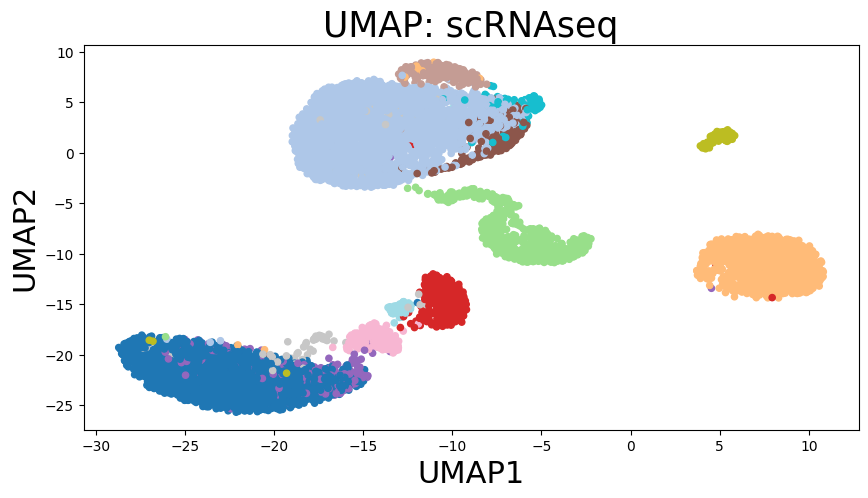

In [29]:
from umap import UMAP

# Converts the original expression matrix (scRNAseq) into a 9-dimensional PCA space
x_reduced = PCA(n_components=9).fit_transform(x)  # x_scRNAseq

# Initializes UMAP with the PCA components
model = UMAP(
    n_components=2,
    min_dist=1,
    n_neighbors=93,
    init=x_reduced[:, 0:2],
    # it is recommended to use the first two components of PCA for initialization of UMAP and t-SNE
    n_epochs=1000,
    verbose=2,
)

# Runs the UMAP algorithm on the PCA transformed data
umap = model.fit_transform(x_reduced)
clear_output()
# Plots the results of the UMAP transformation
plt.figure(figsize=(10, 5))
plt.scatter(umap[:, 0], umap[:, 1], c=y, cmap="tab20", s=20)
plt.title("UMAP: scRNAseq", fontsize=25)
plt.xlabel("UMAP1", fontsize=22)
plt.ylabel("UMAP2", fontsize=22)
plt.show()

### Важные параметры UMAP



`n_neighbors` — число соседей, которые ищутся для каждой точки. Влияет на то, насколько глобально мы смотрим на структуру данных.


`min_dist` — влияет на то, насколько близко могут находиться между собой точки в новом представлении.

`metric` — определяет, как считаются расстояния между точками. По умолчанию Евклидово расстояние, но это не всегда дает лучший результат.

### Преимущества перед t-SNE



* **Скорость работы**

Выдает результаты, похожие на t-SNE, но  работает в разы быстрее

<center><img src="https://ml.gan4x4.ru/msu/dep-2.2/L04/umap_tsne_performance.png" width="450"/></center>

<center><em>Source: <a href="https://umap-learn.readthedocs.io/en/latest/performance.html">Performance Comparison of Dimension Reduction Implementations</a></em></center>

* **Возможность проецировать новые точки**

UMAP может проецировать точки из новых датасетов на уже имеющееся представление.



* **Может объединять представления**

Если у вас есть признаки, сильно отличающиеся по своим свойствам, то можно построить для них представления отдельно с разными метриками, а далее объединить их.




* **Более интуитивные параметры**

Параметры `n_neighbours` и `min_dist` намного понятнее их аналога — `perplexity`.

* **Можно использовать для отображения и в пространства бо́льшей размерности**

Кроме того, его можно использовать для понижения размерности не только до 2–3 (в целях визуализации), но и для больших размерностей, с которыми потом работать другими методами (хотя здесь надо быть аккуратным, он тоже склонен деформировать дальние расстояния).

* **Расстояния более информативны**

Плохая идея — интерпретировать расстояния между кластерами и их размеры для 2D-представлений.

Но в случае UMAP это менее выражено.

Если же отображать в пространство размерности большей, чем два, то можно получить и очень хорошие представления. Но это все эвристика, может и не повезти.


* **Supervised UMAP**

UMAP позволяет передать в него метки объектов — вы можете получить представление, которое оптимизировано под имеющуюся у вас информацию о кластерах.

* **Semi-Supervised UMAP**

UMAP позволяет передать в него метки **только для части** объектов — вы можете получить представление, которое оптимизировано под имеющуюся у вас информацию о кластерах, но при этом не оставляет без внимания объекты без меток.

### Понижение размерности для улучшения качества кластеризации

Методы понижения размерности, такие как UMAP и t-SNE, могут быть использованы как метод предобработки данных для последующей передачи в [алгоритмы кластеризации на основе плотности 📚[wiki]](https://en.wikipedia.org/wiki/DBSCAN).

Данные методы понижения размерности не полностью сохраняют информацию о плотности распределения объектов при осуществлении проекции в низкоразмерное пространство, поэтому следует относиться к такой предобработке с некоторой осторожностью (рекомендуем ознакомиться с [Clustering on the output of t-SNE ✏️[blog]](https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne)).

Несмотря на эти опасения, все же есть веские причины для использования данных методов понижения размерности в качестве этапа предварительной обработки для кластеризации. Как и при любом подходе к кластеризации, необходимо провести исследование и оценку полученных кластеров, чтобы попытаться валидировать разбиение на них, если это возможно.

Загрузим датасет с одноканальными $8 × 8$ изображениями рукописных цифр:

In [30]:
from sklearn import datasets

digits = datasets.load_digits(n_class=10)
x = digits.data
y = digits.target
n_samples, n_features = x.shape
print(x.shape)

(1797, 64)


Понизим размерность данных $64 \rightarrow 2$ при помощи t-SNE:

In [31]:
from sklearn import manifold


# t-SNE embedding of the digits dataset
tsne = manifold.TSNE(n_components=2, init="pca", random_state=42, learning_rate="auto")
x_tsne = tsne.fit_transform(x)

Понизим размерность данных $64 \rightarrow 2$ при помощи UMAP:

In [32]:
umap = UMAP(n_neighbors=5)
x_umap = umap.fit_transform(x)

Визуализируем результаты:

In [33]:
from matplotlib import offsetbox


def plot_embedding(x, title=None):
    x_min, x_max = np.min(x, 0), np.max(x, 0)
    x = (x - x_min) / (x_max - x_min)  # normalization of x to (0..1) range

    plt.figure()
    ax = plt.subplot(111)
    for i in range(x.shape[0]):
        plt.text(
            x[i, 0],
            x[i, 1],
            str(y[i]),
            color=plt.cm.Set1(y[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    if hasattr(offsetbox, "AnnotationBbox"):
        # only print thumbnails with matplotlib > 1.0
        shown_imgs = np.array([[1.0, 1.0]])  # just something big
        for i in range(x.shape[0]):
            dist = np.sum((x[i] - shown_imgs) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_imgs = np.r_[shown_imgs, [x[i]]]
            img_box = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), x[i]
            )
            ax.add_artist(img_box)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(x.shape[0]):
        plt.text(
            x[i, 0],
            x[i, 1],
            str(y[i]),
            color=plt.cm.Set1(y[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

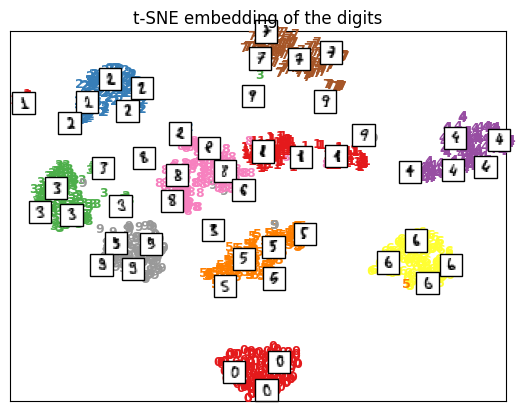

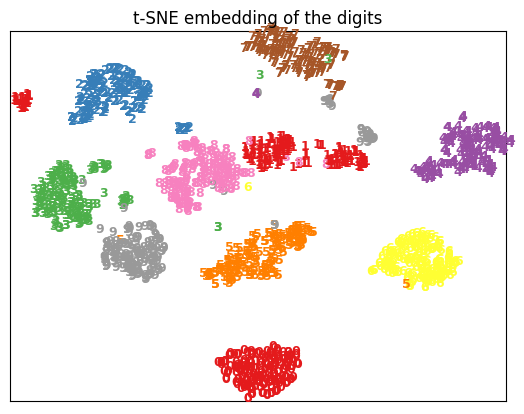

In [34]:
# t-SNE embedding of the digits dataset
plot_embedding(x_tsne, "t-SNE embedding of the digits")

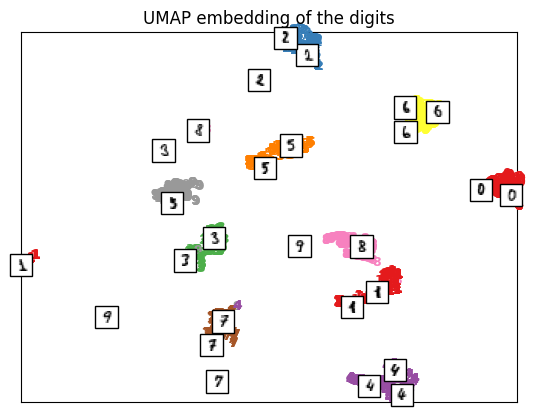

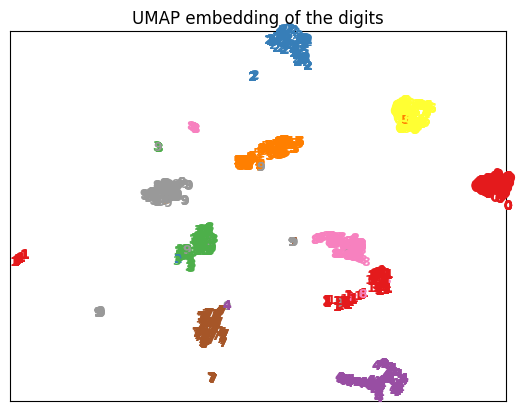

In [35]:
# UMAP embedding of the digits
plot_embedding(x_umap, "UMAP embedding of the digits")

Как нетрудно заметить, при использовании UMAP точки из датасета при проекции в низкоразмерное пространство оказались расположены более "кучно", нежели чем при использовании t-SNE.

Теперь попробуем кластеризовать наши данные при помощи K-Means. Для оценки качества воспользуемся стандартными метриками `adjusted_rand_score` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) и `adjusted_mutual_info_score` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html) из `sklearn.metrics`.

In [36]:
import sklearn.cluster as cluster

kmeans_labels_on_raw = cluster.KMeans(n_clusters=10, n_init="auto").fit_predict(x)

In [37]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


def plot_clustering_metrics(true_l, pled_l, title):
    ari = adjusted_rand_score(true_l, pled_l)
    ami = adjusted_mutual_info_score(true_l, pled_l)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    plt.title(f"Clustering metrics for {title}\n\n 1.0 is best")
    width = 0.75
    ind = np.arange(2)
    ax.barh(ind, [ari, ami], width)
    ax.grid(axis="x")
    ax.set_xlim([0, 1.0])
    for i, v in enumerate([ari, ami]):
        ax.text(v + 0.01, i, f"{v:1.2f}", color="black")
    ax.set_yticks(ind)
    ax.set_yticklabels(["ARI", "AMI"], minor=False)
    plt.show()

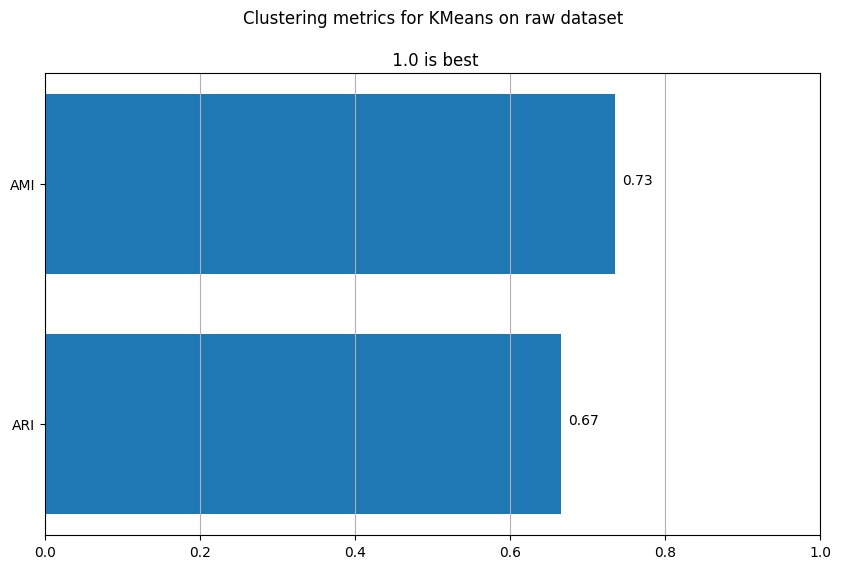

In [38]:
plot_clustering_metrics(y, kmeans_labels_on_raw, "KMeans on raw dataset")

Теперь передадим K-Means данные после понижения размерности:

In [39]:
kmeans_labels_on_x_tsne = cluster.KMeans(n_clusters=10, n_init="auto").fit_predict(
    x_tsne
)
kmeans_labels_on_x_umap = cluster.KMeans(n_clusters=10, n_init="auto").fit_predict(
    x_umap
)

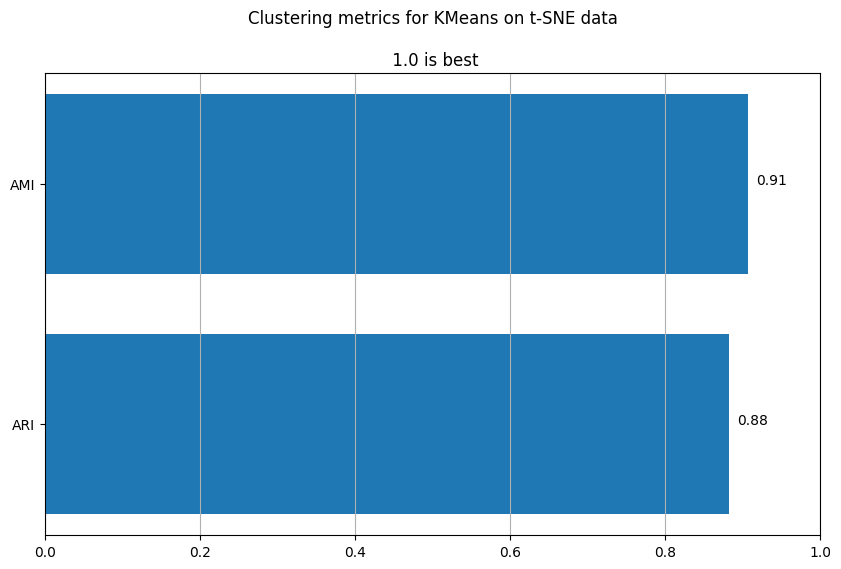

In [40]:
plot_clustering_metrics(y, kmeans_labels_on_x_tsne, "KMeans on t-SNE data")

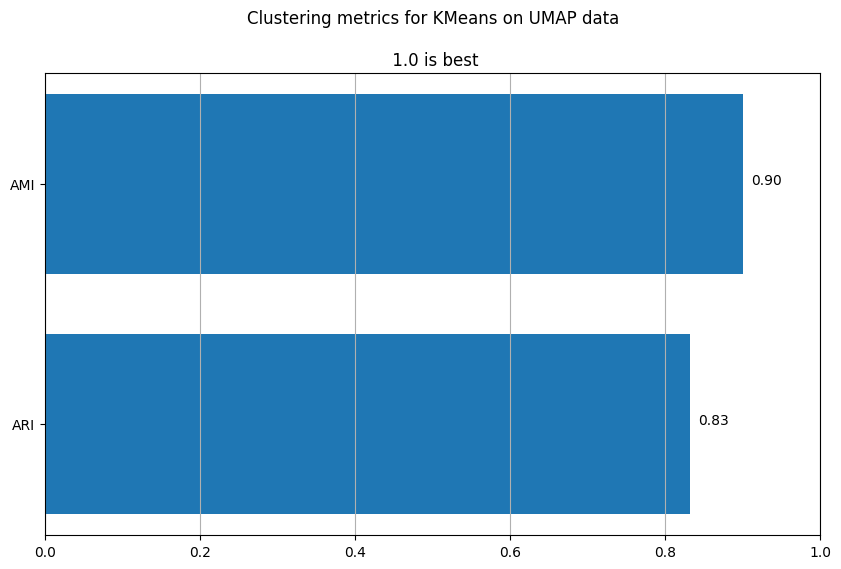

In [41]:
plot_clustering_metrics(y, kmeans_labels_on_x_umap, "KMeans on UMAP data")

Применяя методы понижения размерности на этапе предобработки данных, нам удалось значительно улучшить качество кластеризации. Использование UMAP в разобранном нами примере позволило достичь лучших результатов по сравнению с t-SNE и получить прирост практически в 20% относительно метрик качества кластеризации.